In [60]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [61]:
import math 
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque

In [62]:
tf.__version__
tf.keras.__version__

'2.0.0-alpha0'

'2.2.4-tf'

In [63]:
EPISODES = 500

In [72]:
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = 0.003
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.999
        self.memory = deque(maxlen=2000)
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()
    def build_model(self):
        model = Sequential()
        model.add(Dense(32,input_dim=self.state_size,activation="relu",kernel_initializer="he_uniform"))
        model.add(Dense(32,activation="relu",kernel_initializer="he_uniform"))
        model.add(Dense(self.action_size,activation="linear",kernel_initializer="he_uniform"))
        model.compile(loss="mse",optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model
    def remember(self,state,action,reward, next_state, done):
        self.memory.append((state,action,reward, next_state, done))
    def act(self,state):
        if np.random.rand()<self.epsilon:
            return np.random.choice(np.arange(self.action_size))
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    def replay(self,batch_size):
        if len(self.memory)<batch_size:
            return
        replay_batch = random.sample(self.memory,batch_size)
        for state, action, reward, next_state, done in replay_batch:
            target_val = reward
            if not done:
                target_val = (reward + self.gamma * np.amax(self.target_model.predict(next_state)[0]))
            target = self.model.predict(state)
            target[0][action] = target_val
            #print(target)
            self.model.fit(state, target, epochs = 1, verbose = 0)
        if self.epsilon>self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [73]:
if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQN(state_size, action_size)
    batch_size = 64
    scores = []
    for e in range(EPISODES):
        state = env.reset()
        state = np.reshape(state,[1,state_size])
        score = 0
        render_start = False
        render_end = False
        for time_p in range(500):
            if render_start:
                env.render()
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state,[1,state_size])
            reward = reward if not done else -10
            agent.remember(state,action,reward,next_state, done)
            score += reward
            state = next_state
            agent.replay(batch_size)
            if done:
                agent.update_target_model()
                scores.append(score)
                print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, score, agent.epsilon))
                break
        if render_end:
            env.close()
#         if e % 10 == 0:
#              agent.save("./cartpole-dqn.h5")
            

I0419 13:51:25.754713 140319568906048 registration.py:117] Making new env: CartPole-v1


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_61 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_62 (Dense)             (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_64 (Dense)             (None, 32)                1056      
____________________________

KeyboardInterrupt: 

Text(0.5, 0, 'Episodes')

Text(0, 0.5, 'Scores')

Text(0.5, 1.0, 'DQN Performance')

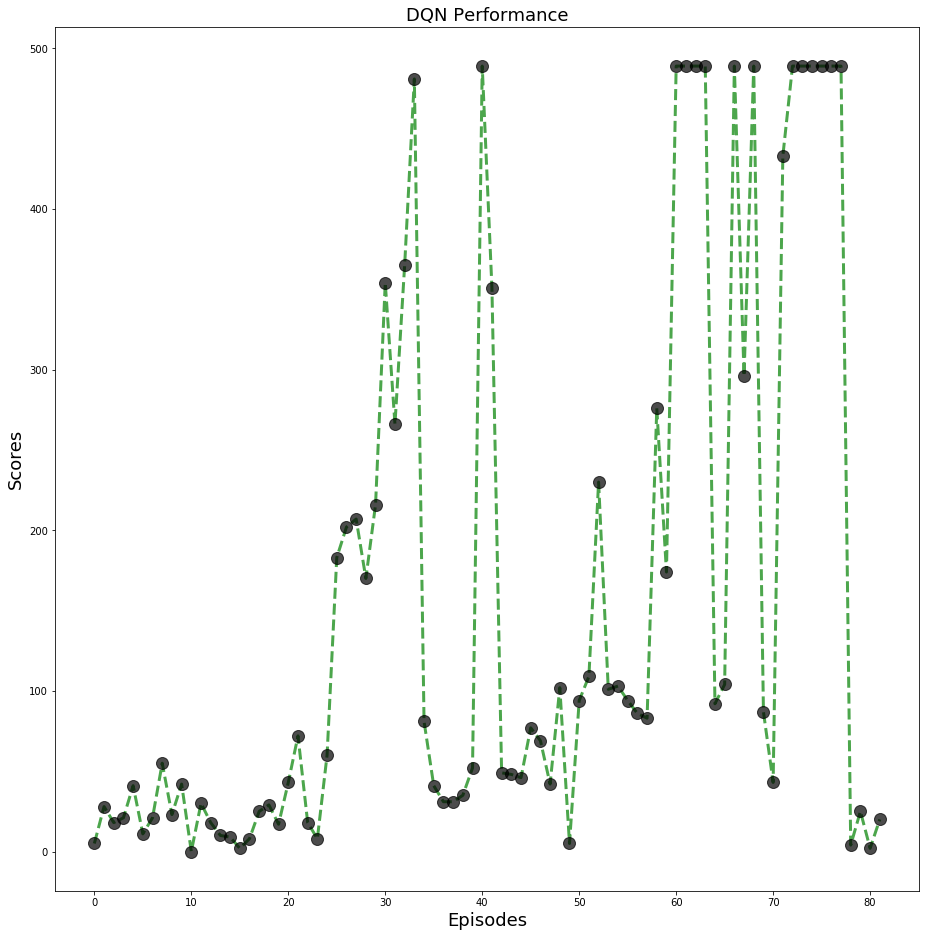

In [83]:
episodes = [i for i in range(len(scores))]
fig = plt.figure(figsize=(12,12))
ax = fig.add_axes([0,0,1,1])
ax.plot(episodes,scores,linewidth=3,alpha=0.7,linestyle="--",marker='o',markersize=12,color='green',markerfacecolor='k',markeredgecolor='k')
ax.set_xlabel("Episodes",fontsize=18)
ax.set_ylabel("Scores",fontsize=18)
ax.set_title("DQN Performance",fontsize=18)